In [2]:
import scipy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import yen
import pandas as pd
import ast

#### *Load Network Topology*

In [3]:
# Load the .mat file
mat_data = scipy.io.loadmat(r'E:\University\Master\Project\Codes\6D-MAN\MAN157Nodes.mat')

# Display the keys in the loaded dictionary
print(mat_data.keys())

net_topology = mat_data['MAN157Nodes']
net_topology_ex = net_topology.copy()

print('the type of net_topology:', type(net_topology_ex))

topo_size = net_topology_ex.shape
print('the shape of net_topology: ', topo_size)

dict_keys(['__header__', '__version__', '__globals__', 'MAN157Nodes'])
the type of net_topology: <class 'numpy.ndarray'>
the shape of net_topology:  (157, 157)


In [4]:
# Make the adjacenccy matrix upper triangular
net_topology_ex = np.triu(net_topology_ex)

In [5]:
# Create graph from adjacency matrix
net_graph = nx.from_numpy_array(net_topology_ex)

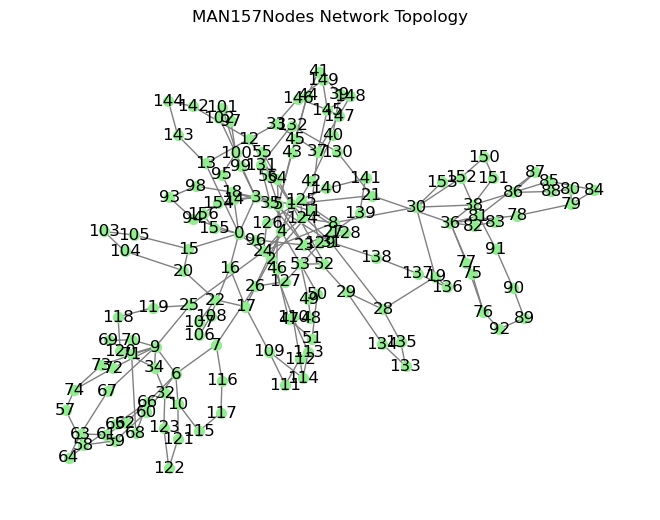

In [6]:
# Draw the graph
nx.draw(net_graph, pos = nx.spring_layout(net_graph), with_labels = True, node_color = 'lightgreen', edge_color='gray', node_size = 50)
plt.title('MAN157Nodes Network Topology')
plt.show()

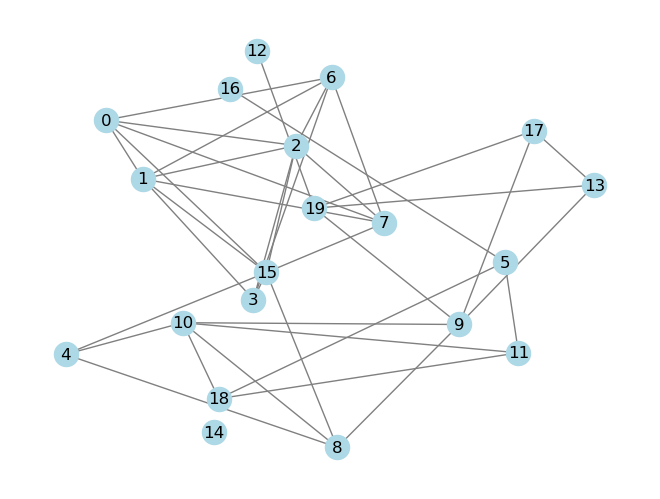

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.random_geometric_graph(20, 0.3)  # Example graph

# pos = nx.spring_layout(G, k=100, iterations=100)  # Adjust k for spacing
pos = nx.spring_layout(G, k=1.5)  # Increase k for more spacing

nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')

plt.show()


#### *Extract all source-destination-weight pairs*

In [8]:
src_des_weight = list(net_graph.edges(data = 'weight'))
src_des_weight_matrix = np.array(src_des_weight)

print('the shape of source-destination-weight matrix:', src_des_weight_matrix.shape)

the shape of source-destination-weight matrix: (220, 3)


##### *Some statistical analysis of links*

In [9]:
num_links = src_des_weight_matrix.shape[0]

print('number of links:', num_links)
print('maximum link weight:', src_des_weight_matrix[:, 2].max())
print('maximum link weight:', src_des_weight_matrix[:, 2].min())
print('average link weight:', src_des_weight_matrix[:, 2].mean())

number of links: 220
maximum link weight: 65.67
maximum link weight: 0.7
average link weight: 11.137363636363638


##### *Calculate the number of optical amplifier spans required for signal transmission*

In [10]:
# Define span length of 70 km
span_length = 70

# Calculate the number of spans required for each link
num_spans_per_link = np.ceil(src_des_weight_matrix[:, 2] / span_length)

#### *Node categorization into hierarchical levels*

In [11]:
# manually assign nodes 2 and 6 into HL1 level
HL1_StandAlone = np.array([1, 5])

# manually assign nodes [0 2 3 4] into HL1 level
HL2_StandAlone = np.array([0, 2, 3, 4])

# manually assign nodes 6 to 38 into HL1 level
HL3_StandAlone = np.arange(6, 39)

# manually assign nodes 39:topo_size(1) into HL1 level
HL4_StandAlone = np.arange(39, topo_size[1])

# concatenated HL1, HL2, HL3 nodes
HL123_standalone = np.concatenate((HL1_StandAlone, HL2_StandAlone, HL3_StandAlone))

# there is a colocated HL4 router in each upper level routers (HL1, HL2, HL3)
HL4_colocated = np.sort(HL123_standalone)

# concatenate all HL4 nodes consist of standalone and colocated
HL4_all = np.concatenate((HL4_colocated, HL4_StandAlone))

# there is colocated HL3 routers in HL1 and HL2 nodes
HL3_colocated = np.concatenate((HL1_StandAlone, HL2_StandAlone))

# there is colocated HL2 routers in HL1 nodes
HL2_colocated = HL1_StandAlone

##### *Calculate node degree of each hierarchical level nodes*


In [12]:
# Create a subgraph containing only edges where at least one node is in HL4 standalone
edges_in_subgraph = [(u, v) for u, v in net_graph.edges if u in HL4_StandAlone or v in HL4_StandAlone]

# calculate HL4 subnet graphs
HL4_subgraph = net_graph.edge_subgraph(edges_in_subgraph).copy()

# calculate node degree of different HLx
HL4_degrees = np.array(net_graph.degree(HL4_StandAlone))
HL3_degrees = np.array(net_graph.degree(HL3_StandAlone))
HL2_degrees = np.array(net_graph.degree(HL2_StandAlone))
HL1_degrees = np.array(net_graph.degree(HL1_StandAlone))

##### *Some statistical analysis of node degrees*

In [13]:
print('maximum node degree of HL4 routers:', HL4_degrees.max(axis = 0)[1])
print('minimum node degree of HL4 routers:', HL4_degrees.min(axis = 0)[1])
print('average node degree of HL4 routers:', HL4_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL3 routers:', HL3_degrees.max(axis = 0)[1])
print('minimum node degree of HL3 routers:', HL3_degrees.min(axis = 0)[1])
print('average node degree of HL3 routers:', HL3_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL2 routers:', HL2_degrees.max(axis = 0)[1])
print('minimum node degree of HL2 routers:', HL2_degrees.min(axis = 0)[1])
print('average node degree of HL2 routers:', HL2_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL1 routers:', HL1_degrees.max(axis = 0)[1])
print('minimum node degree of HL1 routers:', HL1_degrees.min(axis = 0)[1])
print('average node degree of HL1 routers:', HL1_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')


maximum node degree of HL4 routers: 5
minimum node degree of HL4 routers: 2
average node degree of HL4 routers: 2.2711864406779663
-----------------------------------------------------------------
maximum node degree of HL3 routers: 8
minimum node degree of HL3 routers: 3
average node degree of HL3 routers: 3.9393939393939394
-----------------------------------------------------------------
maximum node degree of HL2 routers: 8
minimum node degree of HL2 routers: 5
average node degree of HL2 routers: 6.75
-----------------------------------------------------------------
maximum node degree of HL1 routers: 8
minimum node degree of HL1 routers: 7
average node degree of HL1 routers: 7.5
-----------------------------------------------------------------


#### *Plot HL4 subnet graph*

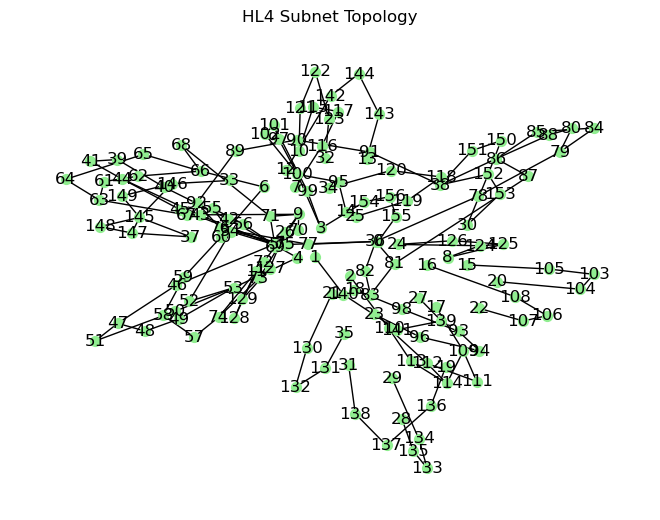

In [14]:
nx.draw(HL4_subgraph, pos = nx.spring_layout(net_graph), with_labels = True, node_color = 'lightgreen', node_size = 50)
plt.title('HL4 Subnet Topology')
plt.show()

#### *Define Cost Matrices*

In [15]:
# Define cost matrix of whole network
netCostMatrix = nx.to_numpy_array(net_graph, weight='weight', nonedge = np.inf)

# Define cost matrix of HL4 subnet
netCostMatrix_HL4 = nx.to_numpy_array(HL4_subgraph, weight='weight', nonedge = np.inf)

#### *Define some parameters*

In [16]:
# define target BER
target_ber = 1e-2

# multi-format loss factors - commented suggest no loss cosideration
phi_MFL =  -1 * [1, 1, 2/3, 17/25, 69/100, 13/21]
# phi_MFL = zeros(1, 6);

epsilon = 0

# define third-order dispersion coefficient
beta_3 = 0.14e-39
Cr = 0.028 / 1e3 / 1e12

# define attenuation coeff (dB/km)
alpha_db = 0.2

# normalized attenuation coeff
alpha_norm = alpha_db / (10 * np.log10(np.exp(1)) * 1e3)

# group velocity dispersion (s^2/m)
beta_2 = -21.7e-27

# define nonlinear parameter (1/(W.m)
gama = 1.21e-3

L_eff_a = 1 / alpha_norm

# noise figure 6 dB
F_C = np.power(10, 0.45)    
F_L = np.power(10, 0.5)         

# Planck's constant (J s)
h_plank = 6.626e-34   

# L_eff is defined as (1 - e ^ (alpha * L_s)) / alpha
L_eff=(1 - np.exp(-1 * alpha_norm * span_length)) / (alpha_norm)


#### *Calculate all HL1, HL2, HL3 nodes that have any connection to HL4s*

In [17]:
# define set to avoid duplicates
HL4_connected_nodes = set() 
for node in HL4_StandAlone:
    HL4_connected_nodes.update(net_graph.neighbors(node))

# Remove the target nodes themselves from the result
HL4_connected_nodes -= set(HL4_StandAlone)

print("Connected higher hierarchical nodes to HL4s:\n", HL4_connected_nodes)

Connected higher hierarchical nodes to HL4s:
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}


#### *K pair link- and node-disjoint shortest paths for HL4 nodes by using DLN_Algorithm*

> ##### Note: *for standalone HL4s we have the primary and secondary, but for colocated HL4 we have only secondary paths. (primary is in it's node)*
> ##### *K_path_attributes's columns --> | 1: source node | 2: destination node | 3: nodes list | 4: distance | 5: links list | 6: number of hops*

##### *Standalone HL4s*

*Define a function to extract all nodes in a certain path*

In [18]:
def nodes_in_path(predecessors, path_index, source, target):
    """Reconstructs the i-th shortest path from the predecessors matrix."""
    path = []
    node = target
    while node != -9999 and node != source:
        path.append(node)
        node = predecessors[path_index, node]
    if node != -9999:
        path.append(source)
        return path[::-1]  # Reverse path to get source-to-target order
    return []  # No path found

*Define a function to extract all links in a certain path*

In [19]:
def links_in_path(all_links, path):
    links_array = []
    for i in range(len(path)):
        if i != len(path) - 1:
            link_idx = np.where(((all_links[:, 0] == path[i]) & (all_links[:, 1] == path[i + 1])) | ((all_links[:, 0] == path[i + 1]) & (all_links[:, 1] == path[i])))[0]
            links_array.append(link_idx[0])

    return links_array

*Calculate K_shortest path between standalone HL4s and possible destinations*

In [20]:
# # create scipy graph to use Yen algorithm
# graph = csr_matrix(netCostMatrix_HL4)

# # all links in the whole network array
# all_links = np.array(list(HL4_subgraph.edges(data = 'weight')))

# # define how many paths will calc between each source-destination pair
# k_paths = 20

# # define a list to store path attributes
# K_path_attributes = []

# # iterate through each standalone HL4 node
# for src in HL4_StandAlone:

#     for dest in HL4_connected_nodes:
#         local_dict = {}
#         # print(src, dest)
#         # K_path_attributes.append(local_dict)
#         dist_array, predecessors = yen(csgraph = graph, source = src, sink = dest, K = k_paths, directed = False, return_predecessors = True)

#         # Reconstruct and display all paths
#         for candidate_path, dist in enumerate(dist_array):
#             path = nodes_in_path(predecessors, candidate_path, src, dest)
#             links_array = links_in_path(all_links, path)
#             local_dict = {}
#             local_dict['src_node'] = src
#             local_dict['dest_node'] = dest
#             local_dict['nodesList'] = path
#             local_dict['distance'] = dist
#             local_dict['linksList'] = links_array
#             local_dict['numHops'] = len(path) - 1

#             K_path_attributes.append(local_dict)
            

# # Convert K_path_attributes list to dataframe
# df = pd.DataFrame(K_path_attributes)

# # save dataframe to csv file
# df.to_csv(r'.\K_path_attributes.csv', index = False)


*Note: we calculate the K_shortest_path once, after that just load the csv file*

In [21]:
K_path_attributes_df = pd.read_csv(r'.\K_path_attributes.csv')
K_path_attributes_df['linksList'] = K_path_attributes_df['linksList'].apply(ast.literal_eval)
K_path_attributes_df['nodesList'] = K_path_attributes_df['nodesList'].apply(ast.literal_eval)

*Check for the first 5 rows of the dataframe*

In [22]:
K_path_attributes_df.head()

,src_node,dest_node,nodesList,distance,linksList,numHops
0,39,4,"[39, 40, 42, 4]",30.0,"[64, 66, 6]",3
1,39,4,"[39, 41, 44, 45, 5, 54, 52, 53, 4]",79.2,"[65, 67, 69, 9, 11, 78, 77, 7]",8
2,39,4,"[39, 41, 44, 43, 5, 54, 52, 53, 4]",80.2,"[65, 67, 68, 8, 11, 78, 77, 7]",8
3,39,4,"[39, 41, 44, 45, 5, 46, 47, 51, 50, 53, 4]",85.7,"[65, 67, 69, 9, 10, 70, 72, 75, 76, 7]",10
4,39,4,"[39, 41, 44, 43, 5, 46, 47, 51, 50, 53, 4]",86.7,"[65, 67, 68, 8, 10, 70, 72, 75, 76, 7]",10


*Filter out all the paths from the source 39 to destination 4*

In [23]:
K_path_attributes_df[(K_path_attributes_df['src_node'] == 39)]

,src_node,dest_node,nodesList,distance,linksList,numHops
0,39,4,"[39, 40, 42, 4]",30.0,"[64, 66, 6]",3
1,39,4,"[39, 41, 44, 45, 5, 54, 52, 53, 4]",79.2,"[65, 67, 69, 9, 11, 78, 77, 7]",8
2,39,4,"[39, 41, 44, 43, 5, 54, 52, 53, 4]",80.2,"[65, 67, 68, 8, 11, 78, 77, 7]",8
3,39,4,"[39, 41, 44, 45, 5, 46, 47, 51, 50, 53, 4]",85.7,"[65, 67, 69, 9, 10, 70, 72, 75, 76, 7]",10
4,39,4,"[39, 41, 44, 43, 5, 46, 47, 51, 50, 53, 4]",86.7,"[65, 67, 68, 8, 10, 70, 72, 75, 76, 7]",10
5,39,4,"[39, 41, 44, 45, 5, 56, 55, 54, 52, 53, 4]",99.2,"[65, 67, 69, 9, 12, 80, 79, 78, 77, 7]",10
6,39,4,"[39, 41, 44, 43, 5, 56, 55, 54, 52, 53, 4]",100.2,"[65, 67, 68, 8, 12, 80, 79, 78, 77, 7]",10
7,39,4,"[39, 41, 44, 45, 5, 46, 47, 48, 49, 53, 4]",106.0,"[65, 67, 69, 9, 10, 70, 71, 73, 74, 7]",10
8,39,4,"[39, 41, 44, 43, 5, 46, 47, 48, 49, 53, 4]",107.0,"[65, 67, 68, 8, 10, 70, 71, 73, 74, 7]",10
9,39,5,"[39, 41, 44, 45, 5]",37.0,"[65, 67, 69, 9]",4


##### *Colocated HL4s*

In [24]:
# # define how many paths will calc between each source-destination pair
# k_paths = 20

# # define a list to store path attributes
# K_path_attributes_colocated = []

# # iterate through each colocated HL4 node
# for src in HL4_colocated:

#     for dest in HL4_connected_nodes:
#         local_dict = {}

#         if src != dest:
            
#             # K_path_attributes.append(local_dict)
#             dist_array, predecessors = yen(csgraph = graph, source = src, sink = dest, K = k_paths, directed = False, return_predecessors = True)

#             # Reconstruct and display all paths
#             for candidate_path, dist in enumerate(dist_array):
#                 path = nodes_in_path(predecessors, candidate_path, src, dest)
#                 links_array = links_in_path(all_links, path)

#                 local_dict = {}
#                 local_dict['src_node'] = src
#                 local_dict['dest_node'] = dest
#                 local_dict['nodesList'] = path
#                 local_dict['distance'] = dist
#                 local_dict['linksList'] = links_array
#                 local_dict['numHops'] = len(path) - 1

#                 K_path_attributes_colocated.append(local_dict)

# # Convert K_path_attributes list to dataframe
# df = pd.DataFrame(K_path_attributes_colocated)

# # save dataframe to csv file
# df.to_csv(r'.\K_path_attributes_colocated.csv', index = False)


*Note: we calculate the K_shortest_path once, after that just load the csv file*

In [25]:
K_path_attributes_colocated_df = pd.read_csv(r'.\K_path_attributes_colocated.csv')
K_path_attributes_colocated_df['linksList'] = K_path_attributes_colocated_df['linksList'].apply(ast.literal_eval)
K_path_attributes_colocated_df['nodesList'] = K_path_attributes_colocated_df['nodesList'].apply(ast.literal_eval)

*Check for the first 5 rows of the dataframe*

In [26]:
K_path_attributes_colocated_df.head()

,src_node,dest_node,nodesList,distance,linksList,numHops
0,0,3,"[0, 155, 156, 154, 3]",62.0,"[0, 165, 164, 5]",4
1,0,14,"[0, 155, 156, 154, 3, 100, 95, 14]",98.0,"[0, 165, 164, 5, 4, 118, 29]",7
2,0,14,"[0, 155, 156, 154, 3, 99, 101, 102, 100, 95, 14]",123.0,"[0, 165, 164, 5, 3, 121, 123, 122, 118, 29]",10
3,0,14,"[0, 155, 156, 154, 3, 99, 101, 97, 100, 95, 14]",125.0,"[0, 165, 164, 5, 3, 121, 120, 119, 118, 29]",10
4,1,27,"[1, 140, 141, 139, 27]",33.0,"[1, 152, 151, 43]",4


*Filter out all the paths from the source 39 to destination 4*

In [27]:
K_path_attributes_colocated_df[(K_path_attributes_colocated_df['src_node'] == 24)]

,src_node,dest_node,nodesList,distance,linksList,numHops
67,24,8,"[24, 124, 8]",9.0,"[39, 16]",2
68,24,8,"[24, 124, 125, 8]",16.0,"[39, 141, 17]",3
69,24,8,"[24, 126, 125, 8]",21.0,"[40, 142, 17]",3
70,24,8,"[24, 126, 125, 124, 8]",30.0,"[40, 142, 141, 16]",4


*Plot the subnet topology for double check*

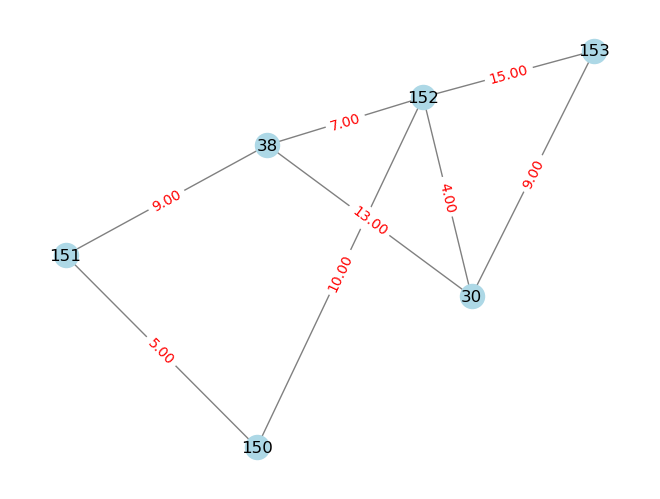

In [28]:
nodes = np.array([38, 151, 150, 152, 153, 30])
sub_net_local = net_graph.subgraph(nodes)

pos = nx.spring_layout(sub_net_local)  # Use full graph positions for consistency
nx.draw(sub_net_local, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# plot the weights of edges on the graph
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in sub_net_local.edges(data=True)}
nx.draw_networkx_edge_labels(sub_net_local, pos, edge_labels=edge_labels, font_color='red')

plt.show()

#### *Calculate Primary and Secondary paths of each source-destination pair*

##### *Standalone HL4s*

*Sort the K_path_attribute dataframe based on numHops and distance in order*

In [29]:
K_paths_sorted = K_path_attributes_df.groupby(['src_node'], group_keys = False).apply(lambda x: x.sort_values(['numHops', 'distance']))

*Check for the first 5 sorted path*

In [30]:
K_paths_sorted.head()

,src_node,dest_node,nodesList,distance,linksList,numHops
0,39,4,"[39, 40, 42, 4]",30.0,"[64, 66, 6]",3
9,39,5,"[39, 41, 44, 45, 5]",37.0,"[65, 67, 69, 9]",4
10,39,5,"[39, 41, 44, 43, 5]",38.0,"[65, 67, 68, 8]",4
11,39,5,"[39, 40, 42, 4, 53, 52, 54, 5]",72.2,"[64, 66, 6, 7, 77, 78, 11]",7
1,39,4,"[39, 41, 44, 45, 5, 54, 52, 53, 4]",79.2,"[65, 67, 69, 9, 11, 78, 77, 7]",8


*Calculate all secondary paths for each path in the dataframe*

In [31]:
K_paths_sorted

,src_node,dest_node,nodesList,distance,linksList,numHops
0,39,4,"[39, 40, 42, 4]",30.0,"[64, 66, 6]",3
9,39,5,"[39, 41, 44, 45, 5]",37.0,"[65, 67, 69, 9]",4
10,39,5,"[39, 41, 44, 43, 5]",38.0,"[65, 67, 68, 8]",4
11,39,5,"[39, 40, 42, 4, 53, 52, 54, 5]",72.2,"[64, 66, 6, 7, 77, 78, 11]",7
1,39,4,"[39, 41, 44, 45, 5, 54, 52, 53, 4]",79.2,"[65, 67, 69, 9, 11, 78, 77, 7]",8
...,...,...,...,...,...,...
1731,156,3,"[156, 154, 3]",30.0,"[164, 5]",2
1730,156,0,"[156, 155, 0]",32.0,"[165, 0]",2
1732,156,14,"[156, 154, 3, 100, 95, 14]",66.0,"[164, 5, 4, 118, 29]",5
1733,156,14,"[156, 154, 3, 99, 101, 102, 100, 95, 14]",91.0,"[164, 5, 3, 121, 123, 122, 118, 29]",8


> *Note: The secondary paths must be fully disjoint, means don't have shared nodes or links with the primary path*

In [32]:
# standalone_path_storage = []
# primary_path_storage = []
# secondary_path_Storage = []
# numHops_secondary_storage = []
# distance_secondary_storage = []

# # iterate through each standalone HL4 node
# for node in HL4_StandAlone:
#     node_df = K_paths_sorted[K_paths_sorted['src_node'] == node]

#     # iterate through each paths of the selected source node
#     for index, row in node_df.iterrows():

#         # extract the information of primary path
#         dest_primary = row['dest_node']
#         nodes_primary = row['nodesList']
#         links_primary = row['linksList']
        
#         # calculate all candidate secondary paths, they should have different destinations of primary path
#         secondary_df = node_df[node_df['dest_node'] != dest_primary]

#         # iterate through each candidate secondary path
#         for index_secondary, row_secondary in secondary_df.iterrows():

#             # extract the information of candidate secondary path
#             nodes_secondary = row_secondary['nodesList']
#             links_secondary = row_secondary['linksList']

#             # check for the common nodes and links of primary and candidate secondary paths
#             common_nodes = np.intersect1d(nodes_primary, nodes_secondary)
#             common_links = np.intersect1d(links_primary, links_secondary)


#             # there is one common node always that is src_node
#             if common_nodes.size == 1 and common_links.size == 0:

#                 # save the primary path and approved secondary path indices to separate lists
#                 primary_path_storage.append(index)
#                 secondary_path_Storage.append(index_secondary)

#                 # save numHops and distance of approved secondary path to separate lists
#                 numHops_secondary_storage.append(row_secondary['numHops'])
#                 distance_secondary_storage.append(row_secondary['distance'])

# # save all the standalone paths in one array
# standalone_path_storage.append(primary_path_storage) # first row is primary path indices
# standalone_path_storage.append(secondary_path_Storage) # second row is approved secondary path indices
# standalone_path_storage.append(numHops_secondary_storage) # third row is numHops of approved secondary paths
# standalone_path_storage.append(distance_secondary_storage) # fourth row is distance of approved secondary paths

# standalone_path_storage = np.array(standalone_path_storage)

# # convert numpy array of primary-secondary pairs to a dataframe
# standalone_path_df = pd.DataFrame(standalone_path_storage.T, columns = ['primary_path', 'secondary_path', 'numHops_secondary', 'distance_secondary'])

# # save the standalone dataframe
# standalone_path_df.to_csv(r'.\standalone_paths.csv', index = False)

*Load the standalone path pairs dataframe*

In [33]:
standalone_path_df = pd.read_csv(r'.\standalone_paths.csv')

In [34]:
standalone_path_df.head()

,primary_path,secondary_path,numHops_secondary,distance_secondary
0,0.0,9.0,4.0,37.0
1,0.0,10.0,4.0,38.0
2,9.0,0.0,3.0,30.0
3,10.0,0.0,3.0,30.0
4,15.0,24.0,5.0,47.0


*Count the number of secondary paths for each primary path*

In [35]:
print(standalone_path_df.groupby('primary_path')['secondary_path'].count())

primary_path
0.0       2
9.0       1
10.0      1
15.0      2
24.0      1
         ..
1730.0    4
1731.0    1
1732.0    1
1733.0    1
1734.0    1
Name: secondary_path, Length: 450, dtype: int64


*Add src_node column to filtered_standalone_df*

In [36]:
standalone_path_df

,primary_path,secondary_path,numHops_secondary,distance_secondary
0,0.0,9.0,4.0,37.0
1,0.0,10.0,4.0,38.0
2,9.0,0.0,3.0,30.0
3,10.0,0.0,3.0,30.0
4,15.0,24.0,5.0,47.0
...,...,...,...,...
795,1730.0,1733.0,8.0,91.0
796,1730.0,1734.0,8.0,93.0
797,1732.0,1730.0,2.0,32.0
798,1733.0,1730.0,2.0,32.0


In [37]:
standalone_path_df = standalone_path_df.merge(K_path_attributes_df['src_node'].reset_index(), 
                                                      left_on='primary_path', right_on='index', how='left').drop(columns=['index'])

In [38]:
standalone_path_df.head()

,primary_path,secondary_path,numHops_secondary,distance_secondary,src_node
0,0.0,9.0,4.0,37.0,39
1,0.0,10.0,4.0,38.0,39
2,9.0,0.0,3.0,30.0,39
3,10.0,0.0,3.0,30.0,39
4,15.0,24.0,5.0,47.0,40


*Calculate all available standalone HL4*
> *not available nodes doesn't have primary-secondary path at all (with k_path = 10).*

In [39]:
available_HL4_standalone_nodes = standalone_path_df['src_node'].unique()

*Calculate not available standalone HL4s*

In [40]:
nonavailable_standalone_HL4 = np.setdiff1d(HL4_StandAlone, available_HL4_standalone_nodes)

*Calculate the number of primary-secondary pairs available for each standalone HL4 nodes*

In [41]:
num_K_pair_final = standalone_path_df.groupby('src_node')['primary_path'].count().to_numpy()

*Find the index of nonavailable standalone HL4s in standalone HL4 nodes*

In [42]:
indices = [np.where(HL4_StandAlone == val)[0][0] if val in HL4_StandAlone else -1 for val in nonavailable_standalone_HL4]

*Insert zero to the index of nonavailable standalone HL4 nodes*

In [43]:
num_K_pair_final = np.insert(num_K_pair_final, indices, 0)

In [44]:
num_K_pair_final

array([ 4,  4,  4,  4,  2,  4,  2,  4,  4,  2,  2,  2,  2,  4,  8,  4,  2,
        2,  4,  4,  4,  4,  2,  2,  4,  2,  2,  8,  4,  4,  2,  2,  4,  2,
        2,  4,  8, 16,  8, 18, 20, 10, 20, 10, 10, 10, 10, 40, 20, 10, 20,
       20, 20, 20,  2,  2, 12,  2,  4,  2,  8, 12,  8,  4,  2,  2,  2,  2,
        2,  2,  8,  8,  4,  6,  4,  6,  4,  4,  4,  2,  2,  2,  4,  4,  4,
        6,  6,  4,  4,  2,  4,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2, 12, 12,  8,  4,  6, 28, 28, 56, 22,  8,  8,  8],
      dtype=int64)

##### *Colocated HL4s*

> *Note: for the colocated HL4s there are only secondary paths*

*Sort the K_path_attribute_colocated dataframe based on numHops and distance in order*

In [45]:
K_paths_sorted_colocated = K_path_attributes_colocated_df.groupby(['src_node', 'dest_node'], group_keys = False).apply(lambda x: x.sort_values(['numHops', 'distance']))

In [46]:
K_paths_sorted_colocated

,src_node,dest_node,nodesList,distance,linksList,numHops
0,0,3,"[0, 155, 156, 154, 3]",62.0,"[0, 165, 164, 5]",4
1,0,14,"[0, 155, 156, 154, 3, 100, 95, 14]",98.0,"[0, 165, 164, 5, 4, 118, 29]",7
2,0,14,"[0, 155, 156, 154, 3, 99, 101, 102, 100, 95, 14]",123.0,"[0, 165, 164, 5, 3, 121, 123, 122, 118, 29]",10
3,0,14,"[0, 155, 156, 154, 3, 99, 101, 97, 100, 95, 14]",125.0,"[0, 165, 164, 5, 3, 121, 120, 119, 118, 29]",10
4,1,27,"[1, 140, 141, 139, 27]",33.0,"[1, 152, 151, 43]",4
...,...,...,...,...,...,...
149,38,36,"[38, 86, 85, 84, 79, 78, 36]",48.7,"[60, 109, 108, 103, 101, 55]",6
150,38,36,"[38, 86, 87, 81, 83, 82, 36]",62.2,"[60, 110, 106, 105, 107, 57]",6
153,38,36,"[38, 86, 88, 80, 79, 78, 36]",69.0,"[60, 111, 104, 102, 101, 55]",6
151,38,36,"[38, 91, 90, 89, 92, 76, 75, 36]",67.0,"[61, 114, 112, 113, 100, 98, 53]",7


> *There are 5 paths between each colocated source-node pair*

#### *Simulating aggregated traffic at HL4s*

##### *generate port capacity for HL4 nodes uisng Monte Carlo simulation*

In [47]:
monteCarlo_steps = 100
min_HL4_rate = 20
max_HL4_rate = 200

# storage for random capacities in each Monte Carlo step
random_capacity_storage = []

for i in range(monteCarlo_steps):

    # set random seed to make our random numbers constant in different runs
    np.random.seed(20)
    # create random capacity for each HL4 node (standalone & colocated) uniformly distributed
    random_capacity_local = np.random.uniform(min_HL4_rate, max_HL4_rate, size = len(HL4_all))
    random_capacity_storage.append(random_capacity_local)

random_capacity_storage = np.array(random_capacity_storage)

# average over Monte Carlo steps to find a final capacity for each HL4 node
HL4_capacity_final = random_capacity_storage.mean(axis = 0)

##### *Traffic growth simulation over 10 years*

In [48]:
# set Compounded Annual Growth Rate (CAGR) at 40% per year
CAGR = 0.4

# simulate traffic for 10 years
period_time = 10

HL4_traffic_storage_annual = np.empty(shape = (period_time, len(HL4_all)))
total_traffic_annual = np.empty(shape = (period_time))
added_traffic_annual = np.empty(shape = (period_time, len(HL4_all)))
num_100G_licence_annual = np.empty(shape = (period_time, len(HL4_all)))
residual_capacity_annual = np.empty(shape = (period_time, len(HL4_all)))

# set the capacity of HL4 nodes for first year
HL4_traffic_storage_annual[0, :] = HL4_capacity_final

# calculate total traffic at the fist year
total_traffic_annual[0] = np.sum(HL4_capacity_final)

# calculate added traffic in compare of last year
added_traffic_annual[0, :] = HL4_capacity_final

# calculate the number of 100G licences for the first year for each HL4 node
num_100G_licence_annual[0, :] = np.ceil(HL4_capacity_final / 100)

# calculate the residual capcacity of 100G licences for each HL4 node at the first year
residual_capacity_annual[0, :] = 100 * num_100G_licence_annual[0, :] - HL4_traffic_storage_annual[0, :]

for year in range(1, period_time):

    # 40% increase in the value of traffic per HL4 node in related to the last yeat
    HL4_traffic_storage_annual[year, :] = (1 + CAGR) * HL4_traffic_storage_annual[year - 1, :]

    # calculate total traffic of this year
    total_traffic_annual[year] = np.sum(HL4_traffic_storage_annual[year, :])

    # calcualte the added traffic in compare of last year
    added_traffic_annual[year, :] = HL4_traffic_storage_annual[year, :] - HL4_traffic_storage_annual[year - 1, :]

    # calculate the number of 100G licences for this year for each HL4 node
    num_100G_licence_annual[year, :] = np.ceil(HL4_traffic_storage_annual[year, :] / 100)

    # calculate the residual capcacity of 100G licences for each HL4 node at this year
    residual_capacity_annual[year, :] = 100 * num_100G_licence_annual[year, :] - HL4_traffic_storage_annual[year, :]


#### *Multi-Year and Multi-Homed K-Pair Link and Node-Disjoint Routing and Spectrum Assignemnt*

##### *Define some parameters*

In [49]:
# define channel spacing (fix grid)
channel_spacing = 0.05 # 50 GHz spacing

# define C-band and L-band frequency slots
spectrum_C = np.flip(np.arange(190.65, 196.675, step = channel_spacing)) # 50 GHz spacing
spectrum_L = np.flip(np.arange(184.525, 190.565, step = channel_spacing)) # 50 GHz spacing

# concatenate C-band and KL-band to a sigle frequency spectrum
spectrum = np.concatenate((spectrum_C, spectrum_L))

# define total number of frequency slots
num_fslots = len(spectrum)

# define modulation formats and rolloff factor
MFL = np.arange(4, 12 + 2, 2)
rolloff = 0.1

# define Symbol Rate (baud rate)
SR = 40 * 1e9

# Maximum bit rate supported per BVT
Max_bit_rate_BVT = np.array([400]) # Gbps

# Forward Error Correction (FEC) Rate
FEC_Rate = Max_bit_rate_BVT * (1e9) / (SR * max(MFL))

# calculates the actual channel bandwidth
B_ch = SR * (1 + rolloff)

# compute required spectral width per channel (rounding up to fit slots) 
Channel_Space_HL4 = np.ceil(B_ch / (channel_spacing * 1e12))  * channel_spacing

# compute required frequency slots per BVT
Required_FS_BVT = np.ceil(B_ch / (channel_spacing * 1e12))

# define a matrix storing Fiber Placement (FP) status for each network edge over time  
Year_FP = np.zeros((period_time, net_graph.number_of_edges()))

# similar to Year_FP, but specifically for HL4 colocated nodes
Year_FP_HL4_colocated =  np.zeros((period_time, len(HL4_colocated)))

# separating Standalone and Co-located HL4 Traffic Data
HL4_standalone_traffic_storage_annual = HL4_traffic_storage_annual[:, len(HL4_colocated):]
HL4_colocated_traffic_storage_annual = HL4_traffic_storage_annual[:, 0:len(HL4_colocated)]

added_traffic_annual_standalone = added_traffic_annual[:, len(HL4_colocated):]
added_traffic_annual_colocated = added_traffic_annual[:, 0:len(HL4_colocated)]

# store unallocated bandwidth (residual traffic) for Standalone HL4s 
Residual_Throughput_BVT_standalone_HL4s = np.zeros((period_time, len(HL4_StandAlone)))

# store unallocated bandwidth (residual traffic) for Co-located HL4s
Residual_Throughput_BVT_colocated_HL4s = np.zeros((period_time, len(HL4_colocated)))

# track the number of BVTs deployed for different spectrum bands each year
HL4_BVT_number_all_annual = np.zeros((period_time, len(Max_bit_rate_BVT)))
HL4_BVT_number_Cband_annual = np.zeros((period_time, len(Max_bit_rate_BVT))) # Traditional optical band
HL4_BVT_number_SuperCband_annual = np.zeros((period_time, len(Max_bit_rate_BVT))) # Extended C-band for higher capacity
HL4_BVT_number_SuperCLband_annual = np.zeros((period_time, len(Max_bit_rate_BVT))) # Includes L-band for extreme capacity scaling

# LSP (Label Switched Path) arrays track optical paths over num_FS and links  
LSP_array = np.zeros((num_fslots, net_graph.number_of_edges(), 20)) # track spectrum allocation for all links
LSP_array_Colocated_HL4s = np.zeros((num_fslots, len(HL4_colocated), 20)) # Specifically tracks lightpaths for co-located HL4s

# track how many optical links are deployed per year in different bands
num_link_LBand_annual = np.zeros(period_time)
num_link_SupCBand_annual = np.zeros(period_time)
num_link_CBand_annual = np.zeros(period_time)

# track how many optical links are deployed per year in different bands
num_links_per_node_annual =  np.zeros((period_time, HL4_subgraph.number_of_edges()))

# track the total new fiber placements for each year
Total_effective_FP_new_annual = np.zeros(period_time)

# store GSNR values for different BVTs over multiple years
GSNR_BVT_array = []

# store GSNR data for HL4 nodes over 10 years
GSNR_HL4_10Year = []

# set the bvt_type
BVT_type = 1

In [ ]:
for year in range(1 , period_time + 1):

    # store traffic capacity assigned to each node
    node_capacity_profile = []

    # tracks signal quality (GSNR) per BVT
    GSNR_BVT_per_year = []

    #######################################################
    # Part 1: Spectrum assignment for standalone HL4s
    #######################################################

    for node_idx in range(len(HL4_StandAlone)):

        # get traffic demand for this node in this year
        HL4_needed_traffic = added_traffic_annual_standalone[year - 1, node_idx]
        
        # if it isnt the first year
        if year != 1:
            # subtract residual throughput (unallocated traffic from previous years)
            HL4_pure_throughput_to_assign = HL4_needed_traffic - Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx]

            # store traffic capacity assigned to current node
            node_capacity_profile.append(HL4_pure_throughput_to_assign)

        else: # if it is the first year
            
            HL4_pure_throughput_to_assign = HL4_needed_traffic
            # store traffic capacity assigned to current node
            node_capacity_profile.append(HL4_pure_throughput_to_assign)

        #################
        # BVT selection 
        #################
        if HL4_pure_throughput_to_assign > 0:

            # calc reference traffic based on the year
            if year < 5:

                # refference traffic is on the year = 5
                traffic_ref =  HL4_standalone_traffic_storage_annual[4, node_idx]

            elif (year > 5) and (year < 10):

                # refference traffic is the difference of traffic at year 10 and 5
                traffic_ref =  HL4_standalone_traffic_storage_annual[9, node_idx] - HL4_standalone_traffic_storage_annual[4, node_idx]

            elif (year > 10) and (year < 15):

                # refference traffic is the difference of traffic at year 15 and 10
                traffic_ref =  HL4_standalone_traffic_storage_annual[14, node_idx] - HL4_standalone_traffic_storage_annual[9, node_idx]
            
            # determine how many frequency slots (FS) are required for the selected BVT type 
            BVT_required_FS_HL4 = Required_FS_BVT

            # calculate the number of BVTs needed to handle the assigned throughput
            BVT_number  = int(np.ceil(HL4_pure_throughput_to_assign / Max_bit_rate_BVT[0]))
            
            # update BVT allocation tracking, multiplying by 4 ?????
            HL4_BVT_number_all_annual[year - 1, BVT_type - 1] = HL4_BVT_number_all_annual[year - 1, BVT_type - 1]  + 4 * BVT_number


            ##############################################################
            # Routing, MF, spectrum, L-band, and new fiber assignment 
            ##############################################################

            # extract precomputed K-shortest paths for the current standalone HL4 
            candidate_path_pair = standalone_path_df[standalone_path_df['src_node'] == HL4_StandAlone[node_idx]]

            # unitialize cost function array with inf
            cost_func = np.inf * np.ones(4)

            # store primary and secondary destination nodes for HL4 standalone paths
            HL4_standalone_dest_primary = []
            HL4_standalone_dest_secondary = []

            # keep track of spectrum assignments across different bands
            HL4_BVT_CBand_count_Kpair  = []
            HL4_BVT_SuperCBand_count_Kpair   = []
            HL4_BVT_SuperCLBand_count_Kpair = []

            # store GSNR for primary and secondary paths
            GSNR_BVT_Kpair_BVTnum_primary = []
            GSNR_BVT_Kpair_BVTnum_secondary = []

            # iterate through each candidate pair for this Standalone HL4 node
            for _, candidate in candidate_path_pair.iterrows():

                # define a variable to track frequency slots (FS) occupied per year
                Year_FP_pair = Year_FP
                
                # track Label Switched Paths (LSPs) for allocated routes
                LSP_array_pair = LSP_array
                
                # initialize counters for BVT allocations in different spectrum bands
                HL4_BVT_CBand_count = 0
                HL4_BVT_superCBand_count  = 0
                HL4_BVT_superCLBand_count  = 0

                ############################
                # Subpart 1: Primary path
                ############################

                # extract the link list for the primary path from K_path_attributes_df
                linkList_primary = K_path_attributes_df.iloc[int(candidate['primary_path'])]['linksList']

                # extract the number of hops for the primary path from K_path_attributes_df
                numHops_primary = K_path_attributes_df.iloc[int(candidate['primary_path'])]['numHops']

                # extract the destination node of the primary path from K_path_attributes_df
                destination_primary = K_path_attributes_df.iloc[int(candidate['primary_path'])]['dest_node']

                # initialize FP_counter_links with ones, representing the first available fiber pair for each link 
                FP_counter_links = np.ones(len(linkList_primary), dtype = np.int8)

                # store congested links in the primary path
                link_congested_primary = np.zeros(len(linkList_primary))

                # iterate through each link in the primary path
                for link_idx in range(len(linkList_primary)):

                    # calc congestion as the number of nonzero elements in LSP_array for each link in the primary path
                    link_congested_primary[link_idx] = np.count_nonzero(LSP_array_pair[:, linkList_primary[link_idx], FP_counter_links[link_idx]])
                
                # sort the primary path links based on congestion value in descending order
                sorted_indices = np.argsort(link_congested_primary)[::-1]
                linkList_primary_sorted = np.array(linkList_primary)[sorted_indices]

                ##################################
                #  fiber and spectrum assignment
                ##################################

                # define a counter for links
                link_counter = 0
                
                # initialize an array for Maximum frequency slot used
                f_max_primary = [] 
                
                # initialize an array for Cost function values
                cost_FP_all_BVT_primary = []  

                # initialize an array for Maximum fiber pairs assigned
                FP_max_primary  = []
                FP_max_secondary = []

                # iterate through BVTs
                for BVT_counter in range(BVT_number):
                    
                    # spectrum assignment continues until an available fiber is found
                    Flag_SA_continue_primary = 1

                    # Note: fiber Pair assignment is done based on first fit
                    while Flag_SA_continue_primary:

                        # PST_parimary is a binary vector that will store whether each Frequency Slot is occupied or available
                        PST_parimary = np.empty(num_fslots)

                        # iterate through each frequency slot
                        for FS in range(1, num_fslots):
                            
                            # vector_state_FS will contain one value per link, indicating whether the slot is free (0) or used (1) on a certain link
                            vector_state_FS = np.empty(len(linkList_primary_sorted))

                            # check the status of the current frequency slot (FS) for each link
                            for link_idx in range(len(linkList_primary_sorted)):

                                # LSP_array contain a number for each FS in each link 
                                vector_state_FS[link_idx] = LSP_array[FS, linkList_primary_sorted[link_idx], FP_counter_links[link_idx]] 

                            # check that there is any link that use that frequecy slot ot not
                            if any(vector_state_FS != 0):
                                PST_parimary[FS - 1] = 1
                            elif all(vector_state_FS == 0):
                                PST_parimary[FS - 1] = 0

                            # keep track of the number of contiguous free slots
                            FS_count = 0

                            # PST_vector_aux stores differences in spectrum occupancy
                            PST_vector_aux = np.diff(np.concatenate(([1], PST_parimary, [1])), n = 1)

                            # this flag ensures that if exact-fit slots aren’t found, the first available larger slot is chosen 
                            flag_First_Fit = 1

                            # stores the selected frequency slots
                            FS_primary = []

                            if any(PST_vector_aux != 0):

                                # find the first index that 0 changes to 1 (start of free block)
                                startIndex = np.where(PST_vector_aux < 0)[0][0]

                                # find the first index that 1 changes to 0 (end of free block)
                                endIndex = np.where(PST_vector_aux > 0)[0][0] - 1

                                # compute the length of each contiguous free block
                                duration = endIndex - startIndex + 1

                                # Line 1505 of matlab code

            

KeyboardInterrupt: 

In [56]:
a = np.zeros(10)

if any(a != 0):
    print('hello')